In [1]:
import numpy as np

def RandomBinaryBitGenerator(numBits):
    return np.random.randint(0, 2, numBits)

In [2]:
def QAMmodulator(bits, M):
    #심볼 당 필요한 비트 수
    k = int(np.log2(M))
    # 비트 그룹화
    bitGroups = bits.reshape((-1, k))

    if M == 4:
        # QPSK 변조
        A = 1/np.sqrt(2)
        Q = np.zeros(len(bitGroups)) #실수축
        I = np.zeros(len(bitGroups)) #허수축
        
        for i, bit in enumerate(bitGroups):
            #실수축 매핑
            if bit[0] == 0:
                Q[i] = 1
            elif bit[0] == 1:
                Q[i] = -1
            
            #허수축 매핑
            if bit[1] == 0:
                I[i] = 1
            elif bit[1] == 1:
                I[i] = -1
        
        Q *= A
        I *= A
            
        symbols = Q + 1j * I
            
    elif M == 16:
        # 16QAM 변조
        A = 1/np.sqrt(10)
        Q = np.zeros(len(bitGroups)) #실수축
        I = np.zeros(len(bitGroups)) #허수축
        
        for i, bit in enumerate(bitGroups):
            #실수축 매핑
            if np.array_equal(bit[:2], [0, 0]):
                Q[i] = 3
            elif np.array_equal(bit[:2], [0, 1]):
                Q[i] = 1
            elif np.array_equal(bit[:2], [1, 1]):
                Q[i] = -1
            elif np.array_equal(bit[:2], [1, 0]):
                Q[i] = -3
            
            # 허수축 매핑
            if np.array_equal(bit[2:], [0, 0]):
                I[i] = 3
            elif np.array_equal(bit[2:], [0, 1]):
                I[i] = 1
            elif np.array_equal(bit[2:], [1, 1]):
                I[i] = -1
            elif np.array_equal(bit[2:], [1, 0]):
                I[i] = -3
        
        Q *= A
        I *= A
            
        symbols = Q + 1j * I
    
    return symbols

In [3]:
def ChannelModel(tranSymbols, channelType, SNR_linear):
    #가우시안 노이즈 평균 0, 분산 0.5 고정
    noise_power = np.sqrt(0.5 / SNR_linear)  #노이즈 전력
    noise = noise_power * np.sqrt(0.5) * (np.random.randn(*tranSymbols.shape) + 1j * np.random.randn(*tranSymbols.shape))
    if channelType == "AWGN":
        receivedSymbols = tranSymbols + noise
    elif channelType == "Rayleigh":
        #Rayleigh Fading coefficient 평균 0, 분산 0.5 고정
        h_real = np.sqrt(0.5) * np.random.randn(*tranSymbols.shape)
        h_img = np.sqrt(0.5) * np.random.randn(*tranSymbols.shape)
        
        h = h_real + 1j * h_img #fading 계수
        h_norm = np.abs(h)
        
        receivedSymbols = h_norm * tranSymbols + noise
    
    return receivedSymbols

In [4]:
def QAMdemodulator(receivedSymbols, M):
    k = int(np.log2(M)) #심볼당 필요한 비트 수
    bits = np.zeros((len(receivedSymbols), k), dtype=int)
    
    if M == 4:
        # QPSK 복조
        A = 1/np.sqrt(2)
        Q = np.real(receivedSymbols) / A #실수부 추출
        I = np.imag(receivedSymbols) / A #허수부 추출

        bits[:, 0] = Q < 0  #첫번째 비트: 실수부 값이 음수면 1
        bits[:, 1] = I < 0  #두번째 비트: 허수부 값이 음수면 1

        bits = bits.flatten()
    
    elif M == 16:
        #16QAM 복조
        A = 1/np.sqrt(10)
        Q = np.real(receivedSymbols) / A #실수부 추출
        I = np.imag(receivedSymbols) / A #허수부 추출
        
        bits[:, 0] = Q < 0 #첫번째 비트: 실수부 값이 음수면 1
        bits[:, 1] = np.abs(Q) < 2 #두번째 비트: 실수부 절대 값이 2보다 작으면 1
        bits[:, 2] = I < 0 #세번째 비트: 허수부 값이 음수면 1
        bits[:, 3] = np.abs(I) < 2 #네번째 비트: 허수부 절대 값이 2보다 작으면 1
        bits = bits.flatten()
    
    return bits

In [5]:
def ErrorCounter(transBits, receivedBits, M):
    k = int(np.log2(M))
    
    transSymbols = transBits.reshape((-1, k))
    receivedSymbols = receivedBits.reshape((-1, k))
    
    symbolErrors = np.sum(np.any(transSymbols != receivedSymbols, axis=1))
    totalSymbols = transSymbols.shape[0]
    
    # Symbol Error Rate 계산
    SER = symbolErrors / totalSymbols
    
    return SER

In [6]:
import matplotlib.pyplot as plt
import scipy.special as sp

def qfunc(x):
    return 0.5 * sp.erfc(x / np.sqrt(2))

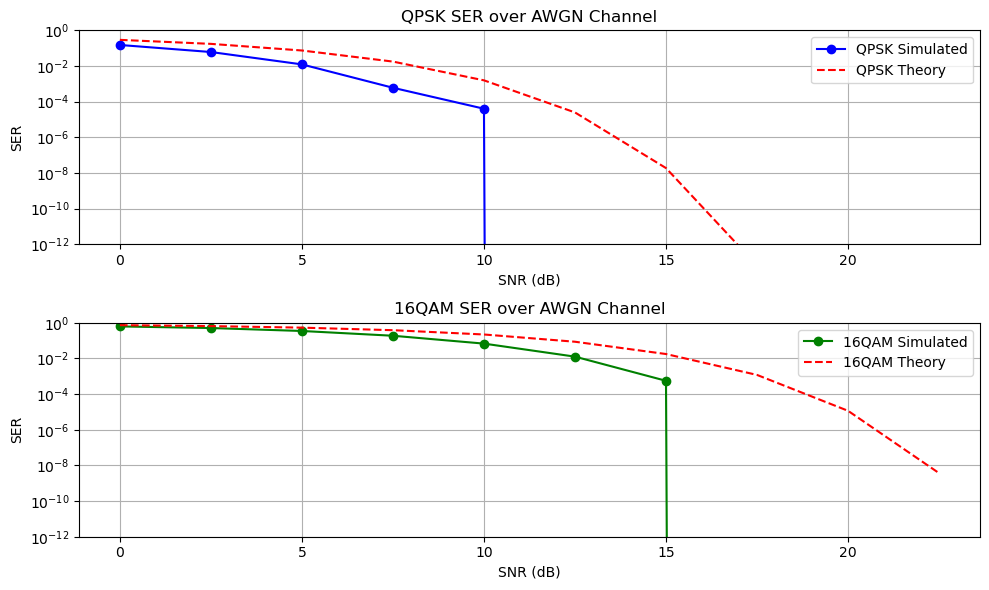

In [7]:
#problem 1 - AWGN channel

SNR_dB_range = np.arange(0, 25, 2.5)
SNR_linear = 10**(SNR_dB_range / 10)

bits = RandomBinaryBitGenerator(100000)
SER_qpsk = np.zeros(len(SNR_dB_range))
SER_16qam = np.zeros(len(SNR_dB_range))

for idx, snr_db in enumerate(SNR_dB_range):
    symbol_qpsk = QAMmodulator(bits, 4)
    symbol_16qam = QAMmodulator(bits, 16)

    received_qpsk = ChannelModel(symbol_qpsk, "AWGN", SNR_linear[idx])
    received_16qam = ChannelModel(symbol_16qam, "AWGN", SNR_linear[idx])

    received_bits_qpsk = QAMdemodulator(received_qpsk, 4)
    received_bits_16qam = QAMdemodulator(received_16qam, 16)

    SER_qpsk[idx] = ErrorCounter(bits, received_bits_qpsk, 4)
    SER_16qam[idx] = ErrorCounter(bits, received_bits_16qam, 16)

SER_qpsk_theory = 1 - (1 - qfunc(np.sqrt(SNR_linear)))**2
SER_16qam_theory = 1 - (1 - (3/2) * qfunc(np.sqrt(SNR_linear / 5)))**2

# 그래프 그리기
plt.figure(figsize=(10, 6))
    
# QPSK 시뮬레이션 결과와 이론적 결과
plt.subplot(2, 1, 1)
plt.semilogy(SNR_dB_range, SER_qpsk, 'bo-', label="QPSK Simulated")
plt.semilogy(SNR_dB_range, SER_qpsk_theory, 'r--', label="QPSK Theory")
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('QPSK SER over AWGN Channel')
plt.legend()
plt.grid(True)
plt.ylim(1e-12, 10**0)  # y축 범위 설정
    
# 16QAM 시뮬레이션 결과와 이론적 결과
plt.subplot(2, 1, 2)
plt.semilogy(SNR_dB_range, SER_16qam, 'go-', label="16QAM Simulated")
plt.semilogy(SNR_dB_range, SER_16qam_theory, 'r--', label="16QAM Theory")
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('16QAM SER over AWGN Channel')
plt.legend()
plt.grid(True)
plt.ylim(1e-12, 10**0)  # y축 범위 설정
    
plt.tight_layout()
plt.show()


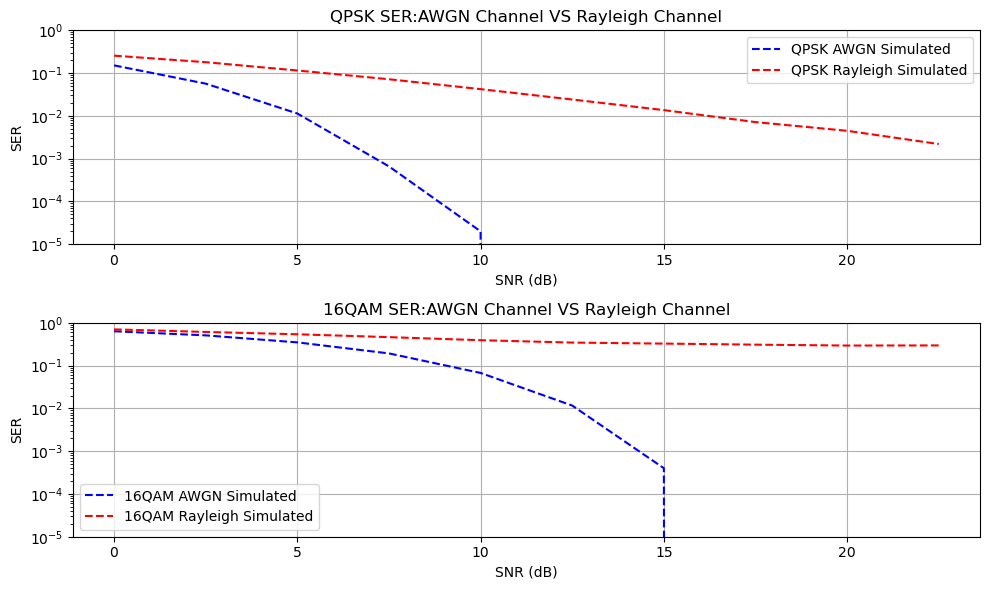

In [15]:
#problem 2 - Rayleigh Fading channel

SNR_dB_range = np.arange(0, 25, 2.5)
SNR_linear = 10**(SNR_dB_range / 10)

bits = RandomBinaryBitGenerator(100000)
SER_qpsk_awgn = np.zeros(len(SNR_dB_range))
SER_16qam_awgn = np.zeros(len(SNR_dB_range))
SER_qpsk_ray = np.zeros(len(SNR_dB_range))
SER_16qam_ray = np.zeros(len(SNR_dB_range))

for idx, snr_db in enumerate(SNR_dB_range):
    #QAM modulate
    symbol_qpsk = QAMmodulator(bits, 4)
    symbol_16qam = QAMmodulator(bits, 16)
    
    #channel에 따른 수신
    received_qpsk_awgn = ChannelModel(symbol_qpsk, "AWGN", SNR_linear[idx])
    received_16qam_awgn = ChannelModel(symbol_16qam, "AWGN", SNR_linear[idx])

    received_qpsk_ray = ChannelModel(symbol_qpsk, "Rayleigh", SNR_linear[idx])
    received_16qam_ray = ChannelModel(symbol_16qam, "Rayleigh", SNR_linear[idx])
    
    #QAM demodulate
    received_bits_qpsk_awgn = QAMdemodulator(received_qpsk_awgn, 4)
    received_bits_16qam_awgn = QAMdemodulator(received_16qam_awgn, 16)

    received_bits_qpsk_ray = QAMdemodulator(received_qpsk_ray, 4)
    received_bits_16qam_ray = QAMdemodulator(received_16qam_ray, 16)
    
    #SER 계산
    SER_qpsk_awgn[idx] = ErrorCounter(bits, received_bits_qpsk_awgn, 4)
    SER_16qam_awgn[idx] = ErrorCounter(bits, received_bits_16qam_awgn, 16)
    
    SER_qpsk_ray[idx] = ErrorCounter(bits, received_bits_qpsk_ray, 4)
    SER_16qam_ray[idx] = ErrorCounter(bits, received_bits_16qam_ray, 16)

# 그래프 그리기
plt.figure(figsize=(10, 6))
    
# QPSK 시뮬레이션 결과와 이론적 결과
plt.subplot(2, 1, 1)
plt.semilogy(SNR_dB_range, SER_qpsk_awgn, 'b--', label="QPSK AWGN Simulated")
plt.semilogy(SNR_dB_range, SER_qpsk_ray, 'r--', label="QPSK Rayleigh Simulated")
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('QPSK SER:AWGN Channel VS Rayleigh Channel')
plt.legend()
plt.grid(True)
plt.ylim(1e-5, 10**0)  # y축 범위 설정
    
# 16QAM 시뮬레이션 결과와 이론적 결과
plt.subplot(2, 1, 2)
plt.semilogy(SNR_dB_range, SER_16qam_awgn, 'b--', label="16QAM AWGN Simulated")
plt.semilogy(SNR_dB_range, SER_16qam_ray, 'r--', label="16QAM Rayleigh Simulated")
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('16QAM SER:AWGN Channel VS Rayleigh Channel')
plt.legend()
plt.grid(True)
plt.ylim(1e-5, 10**0)  # y축 범위 설정
    
plt.tight_layout()
plt.show()


In [9]:
def ChannelModel_MRC(tranSymbols, SNR_linear, num_paths=2):
    #가우시안 노이즈 평균 0, 분산 0.5 고정
    noise_power = np.sqrt(0.5 / SNR_linear)  #노이즈 전력
    
    symbol_num = len(tranSymbols)
    received_signals = np.zeros((num_paths, symbol_num), dtype=complex)
    channel_coeffs = np.zeros((num_paths, symbol_num), dtype=complex)
    for path in range(num_paths):
        #Rayleigh Fading coefficient 평균 0, 분산 0.5 고정
        h_real = np.sqrt(0.5) * np.random.randn(*tranSymbols.shape)
        h_img = np.sqrt(0.5) * np.random.randn(*tranSymbols.shape)
        
        h = h_real + 1j * h_img #fading 계수
        h_norm = np.abs(h)
        channel_coeffs[path, :] = h_norm
        
        noise = noise_power * np.sqrt(0.5) * (np.random.randn(*tranSymbols.shape) + 1j * np.random.randn(*tranSymbols.shape))
        
        received_signals[path, :] = h_norm * tranSymbols + noise
    
    return received_signals, channel_coeffs

def MRC(received_signals, channel_coeffs):
    combined_signal = np.sum(np.conj(channel_coeffs) * received_signals, axis=0)
    #정규화
    combined_signal /= np.sum(np.abs(channel_coeffs)**2, axis=0)
    
    return combined_signal

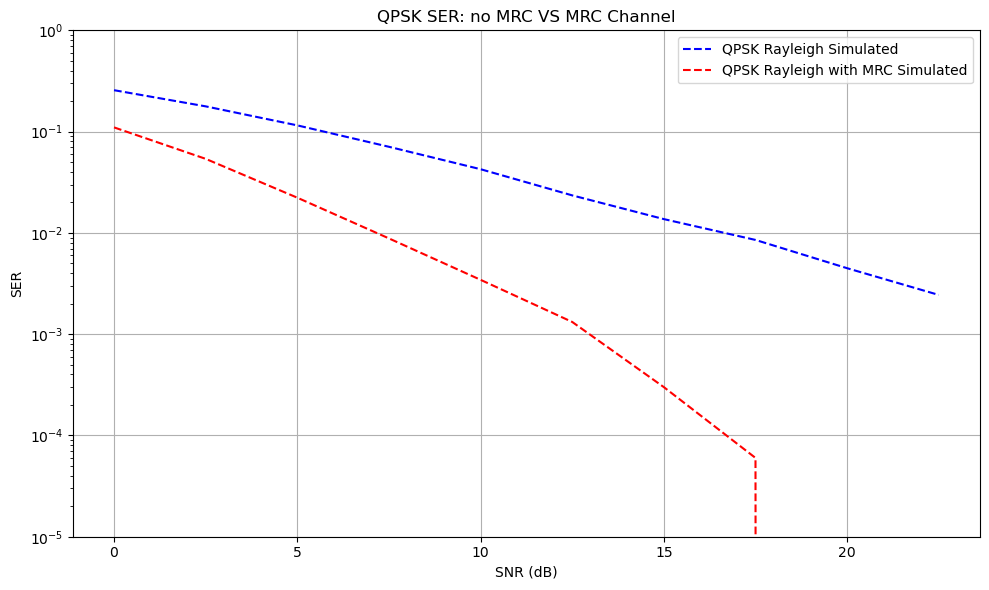

In [14]:
#problem 3 - MRC gain

SNR_dB_range = np.arange(0, 25, 2.5)
SNR_linear = 10**(SNR_dB_range / 10)

bits = RandomBinaryBitGenerator(100000)
SER_qpsk = np.zeros(len(SNR_dB_range))
SER_qpsk_MRC = np.zeros(len(SNR_dB_range))

for idx, snr_db in enumerate(SNR_dB_range):
    #QAM modulate
    symbol_qpsk = QAMmodulator(bits, 4)

    #수신
    received_qpsk = ChannelModel(symbol_qpsk, "Rayleigh", SNR_linear[idx])
    channel_2_qpsk, channel_2_coeffs_qpsk = ChannelModel_MRC(symbol_qpsk, SNR_linear[idx])
    combined_qpsk = MRC(channel_2_qpsk, channel_2_coeffs_qpsk)
    
    #QAM demodulate
    received_bits_qpsk = QAMdemodulator(received_qpsk, 4)
    received_bits_qpsk_mrc = QAMdemodulator(combined_qpsk, 4)

    #SER 계산
    SER_qpsk[idx] = ErrorCounter(bits, received_bits_qpsk, 4)
    SER_qpsk_MRC[idx] = ErrorCounter(bits, received_bits_qpsk_mrc, 4)

# 그래프 그리기
plt.figure(figsize=(10, 6))
    
# QPSK 시뮬레이션 결과와 이론적 결과
plt.semilogy(SNR_dB_range, SER_qpsk, 'b--', label="QPSK Rayleigh Simulated")
plt.semilogy(SNR_dB_range, SER_qpsk_MRC, 'r--', label="QPSK Rayleigh with MRC Simulated")
plt.xlabel('SNR (dB)')
plt.ylabel('SER')
plt.title('QPSK SER: no MRC VS MRC Channel')
plt.legend()
plt.grid(True)
plt.ylim(1e-5, 10**0)  # y축 범위 설정

plt.tight_layout()
plt.show()